In [1]:
import os
import math

from GENE_sim_tools.sims_to_df.src.sims_to_dataframe import filepath_to_sim_df, load_parquet_to_df, save_df_to_parquet, reload_field_data_to_df
from GENE_sim_tools.sims_to_df.src.utils.find_buried_filetypes import find_buried_filetypes

from GENE_sim_tools.sims_to_df.src.field_data_analysis.append_field_analysis import complex_array_resolution_analysis


# Test paths

In [2]:
test_parent_dir = '/pscratch/sd/j/joeschm/NSXTU_discharges/X_TEST'

test_scanfile_dirs = []
for paths in os.listdir(test_parent_dir):
    if paths.startswith('scanfiles'):
        test_scanfile_dirs.append(os.path.join(test_parent_dir, paths))

# print(test_scanfile_dirs)

test_sim_dirs = []
for paths in os.listdir(test_parent_dir):
    if paths.startswith('TEST_3spec'):
        test_sim_dirs.append(os.path.join(test_parent_dir, paths))

# print(test_sim_dirs)

test_param_paths = []
for files in os.listdir(test_scanfile_dirs[0]):
    if files.startswith('parameters_'):
        test_param_paths.append(os.path.join(test_scanfile_dirs[0], files))

for files in os.listdir(test_sim_dirs[0]):
    if files.startswith('parameters'):
        test_param_paths.append(os.path.join(test_sim_dirs[0], files))

# print(test_param_paths)

all_test_paths = [test_parent_dir] + test_scanfile_dirs + test_sim_dirs + test_param_paths

In [3]:
# test_parent_dir = '/pscratch/sd/j/joeschm/NSXTU_discharges/132588/r_0.736_q=4_MTM_mode/convergence_check/nz0_hpyz_edgeopt_scans'

# all_test_paths = find_buried_filetypes(test_parent_dir)

In [4]:
print(len(all_test_paths))

14


In [5]:
# all_test_paths = all_test_paths[:50]
# len(all_test_paths)

# Functions tests

In [6]:
sim_df = filepath_to_sim_df(all_test_paths)

save_df_to_parquet(sim_df, test_parent_dir)

Dropping columns containing arrays or lists: ['field_apar', 'field_bpar', 'field_phi', 'time', 'zgrid']
DataFrame saved to /pscratch/sd/j/joeschm/NSXTU_discharges/X_TEST/sim_df.parquet


In [7]:
sim_df_loaded = load_parquet_to_df('/pscratch/sd/j/joeschm/NSXTU_discharges/X_TEST')

# sim_df_reloaded = reload_field_data_to_df(sim_df_loaded)

Loading /pscratch/sd/j/joeschm/NSXTU_discharges/X_TEST/sim_df.parquet


In [8]:
# print(sim_df['field_phi'][6][6])
# print(sim_df_loaded['field_phi'][6][6])

In [9]:
# # Find duplicate column names
# duplicate_columns = sim_df.columns[sim_df.columns.duplicated()]
# print("Duplicate column names:", duplicate_columns)


In [10]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming sim_df is your DataFrame

# # Step 1: Filter the DataFrame where 'nz0' equals 512
# sim_df_slice = sim_df[(sim_df['nz0'] == 512)]


# # Step 2: Sort the DataFrame by 'kymin'
# sim_df_slice = sim_df_slice.sort_values(by='kymin')

# # Step 3: Extract the columns 'gamma' and 'kymin'
# gammas = sim_df_slice['gamma']
# kymin = sim_df_slice['kymin']

# # Step 4: Create a scatter plot
# # plt.scatter(kymin, gammas)  # for the scatter plot
# plt.plot(kymin, gammas, '-o')  # for the lines connecting the points

# plt.xlabel('kymin')
# plt.ylabel('gamma')
# plt.title('Scatter plot of gamma vs kymin')
# plt.show()


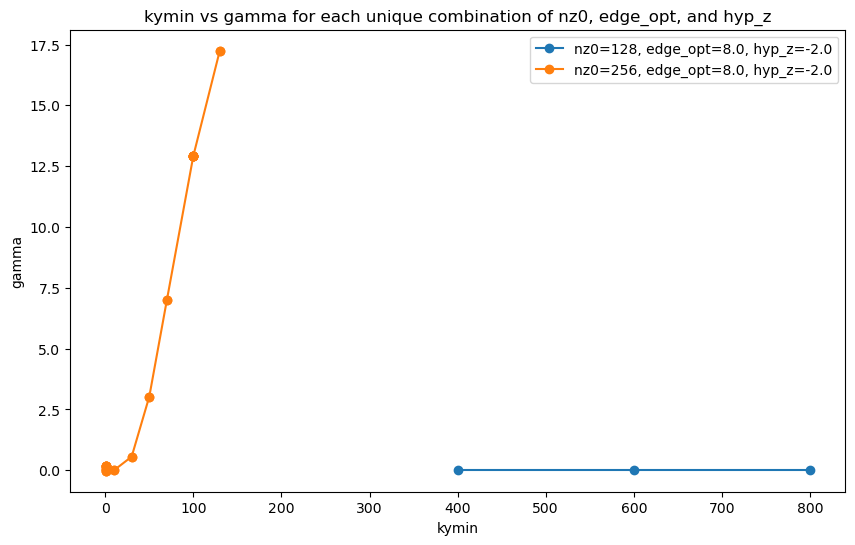

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming sim_df is your DataFrame

# Group the DataFrame by 'nz0', 'edge_opt', and 'hyp_z'
grouped = sim_df.groupby(['nz0', 'edge_opt', 'hyp_z'])

# Plotting
plt.figure(figsize=(10, 6))  # Set figure size for better visibility

for (nz0, edge_opt, hyp_z), group in grouped:
    plt.plot(group['kymin'], group['gamma'], '-o', label=f'nz0={nz0}, edge_opt={edge_opt}, hyp_z={hyp_z}')

plt.xlabel('kymin')
plt.ylabel('gamma')
plt.title('kymin vs gamma for each unique combination of nz0, edge_opt, and hyp_z')
plt.legend()  # Show legend to identify the groups
plt.show()


In [12]:
analysis_sim_df = complex_array_resolution_analysis(sim_df, 'field_phi')

# save_df_to_parquet(analysis_sim_df, test_parent_dir, 'sim_df_RES_CHECK')

In [13]:
# print(analysis_sim_df['phi_fft_info'][6]['ave_freq'])
# print(analysis_sim_df['phi_fft_info'][6]['lower_95_freq'])
# print(analysis_sim_df['phi_fft_info'][6]['upper_95_freq'])

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plotting_function(complex_array, zgrid, field_name, verbose:bool=False):

    if field_name == 'field_phi':
        title = r'$\phi$'
        real_label = r'$Re[\phi]$'
        imag_label = r'$Im[\phi]$'
        abs_label = r'$|\phi|$'
    elif field_name == 'field_apar':
        title = r'$A_{||}$'
        real_label = r'$Re[A_{||}]$'
        imag_label = r'$Im[A_{||}]$'
        abs_label = r'$|A_{||}|$'
    else:
        title = real_label = imag_label = abs_label = ''

    if verbose:
        fig = plt.figure(figsize=(8, 10))
        gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])

        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        ax3 = fig.add_subplot(gs[2])

        # Plot the complex field
        ax1.plot(zgrid, np.real(complex_array), label=real_label, color='red')
        ax1.plot(zgrid, np.imag(complex_array), label=imag_label, color='blue')
        ax1.plot(zgrid, np.abs(complex_array), label=abs_label, color='black')
        ax1.set_title(title)
        ax1.set_xlabel(r'$z/\pi$', size=18)
        ax1.legend()
        ax1.grid(True)

        # # Plot angle difference histogram
        # angles = get_delta_angle_counts(complex_array)
        # print(angles)
        # counts, bins = np.histogram(angles, bins=100)
        # total_samples = len(angles)
        # relative_frequency = counts / total_samples
        # ax2.bar(bins[:-1], relative_frequency, width=np.diff(bins), edgecolor='black', align='edge')
        # ax2.set_title('Histogram of Delta Angles (Relative to Sample Size)')
        # ax2.set_xlabel('Delta Angle (rad)')
        # ax2.set_ylabel('Relative Frequency')

        # # Plot Fourier decomposition
        # norm_freq, norm_mag, _ = compute_fourier_decomposition(complex_array)
        # ax3.stem(norm_freq, norm_mag, 'b', markerfmt=" ", basefmt="-b")
        # ax3.set_title('Normalized Magnitude Spectrum of the Fourier Transform')
        # ax3.set_xlabel('Normalized Frequency')
        # ax3.set_ylabel('Normalized Magnitude')
        # ax3.grid(True)

        plt.tight_layout()
        plt.show()

    else:
        plt.figure(figsize=(8, 4))
        plt.title(title)
        plt.plot(zgrid, np.real(complex_array), label=real_label, color='red')
        plt.plot(zgrid, np.imag(complex_array), label=imag_label, color='blue')
        plt.plot(zgrid, np.abs(complex_array), label=abs_label, color='black')
        plt.xlabel(r'$z/\pi$', size=18)
        plt.legend()
        plt.grid(True)
        plt.show()



Index(['n_procs_s', 'n_procs_v', 'n_procs_w', 'n_procs_x', 'n_procs_y',
       'n_procs_z', 'n_procs_sim', 'n_spec', 'nx0', 'nky0',
       ...
       'field_phi_fft_freq', 'field_phi_rel_mag', 'field_phi_ave_freq',
       'field_phi_lower_95_freq', 'field_phi_upper_95_freq',
       'field_phi_angles', 'field_phi_rel_freq', 'field_phi_ave_angle',
       'field_phi_lower_95_angle', 'field_phi_upper_95_angle'],
      dtype='object', length=168)
0.008523305036976911 0.015273835215868822 0.025238215018488448 0.24972098214285712


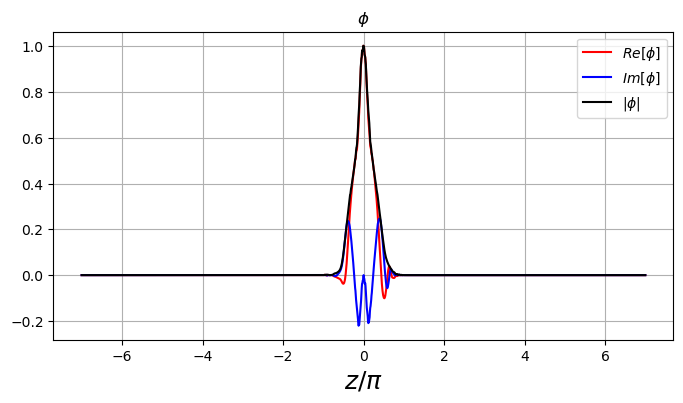

0.008070528104707793 0.015273835215868822 0.026488081146284273 0.24972098214285712


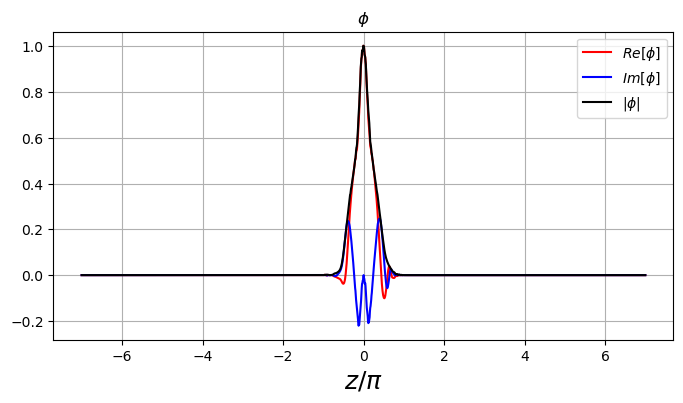

0.21488194444444444 0.2423954683883838 0.2688038194444445 0.24921875000000002


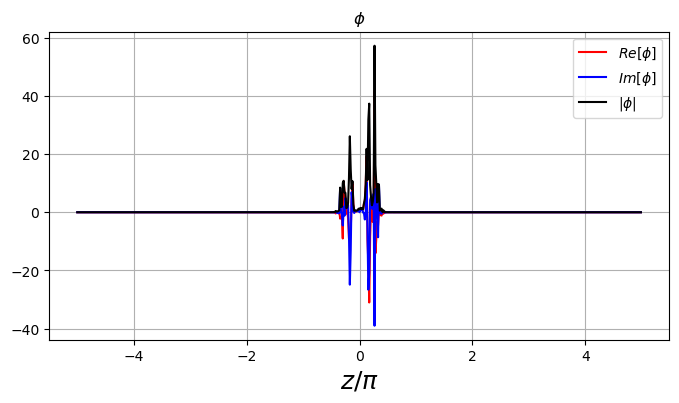

0.24654908854166668 0.2725269028971335 0.29861440972222225 0.24921875000000002


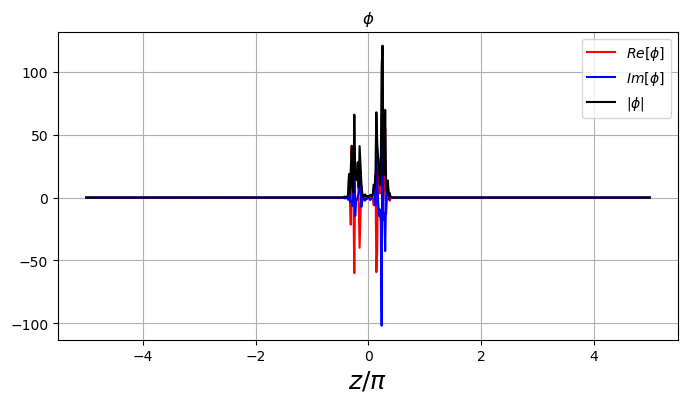

0.22161210937500003 0.24879825466622102 0.27505568576388895 0.24921875000000002


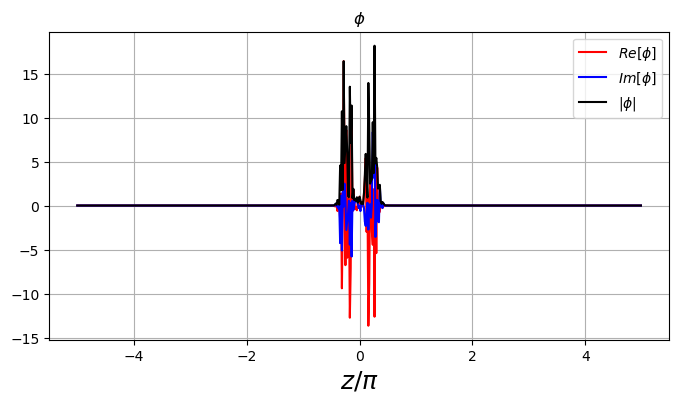

0.008122238005050504 0.015273835351773395 0.0253807325487013 0.24972098214285712


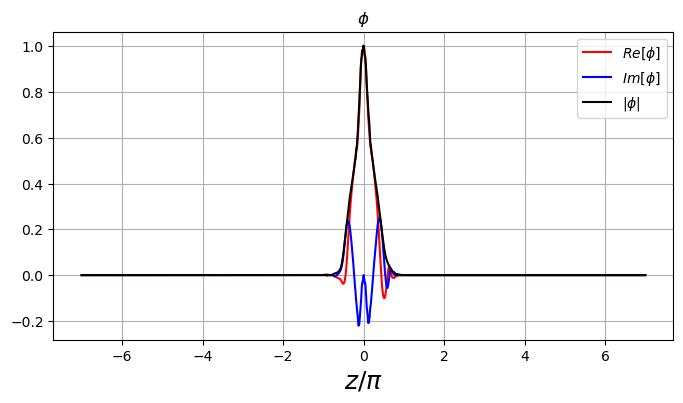

0.008021340638528137 0.015273835351773395 0.024972098214285712 0.24972098214285712


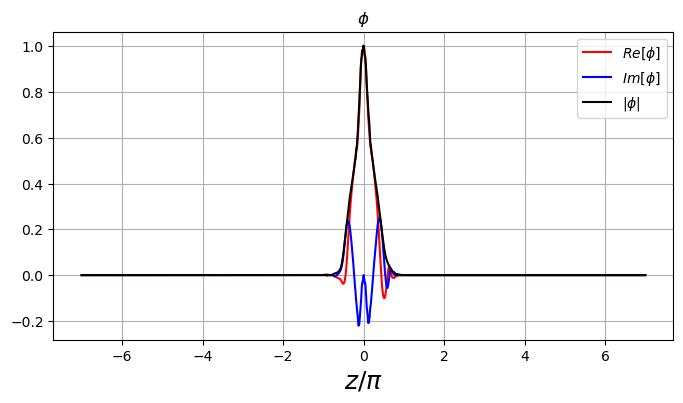

0.008223135371572871 0.015273835215868881 0.0255812660646645 0.24972098214285712


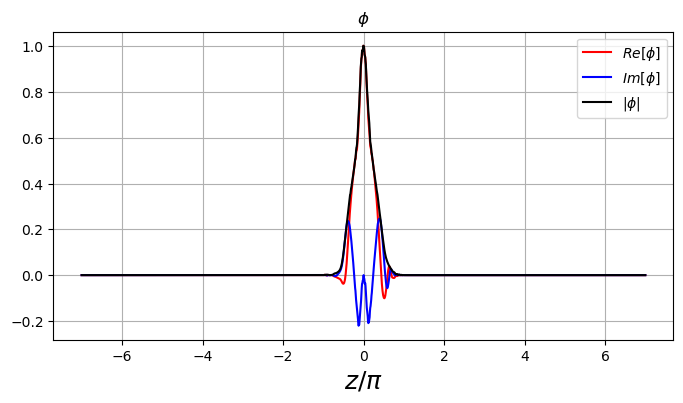

0.007969630738185426 0.015273835215868881 0.026083230463113276 0.24972098214285712


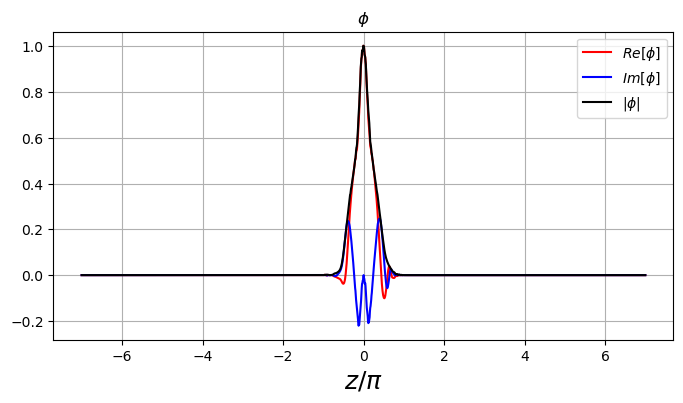

0.006104290674603174 0.009008625582768623 0.014178602430555557 0.24972098214285712


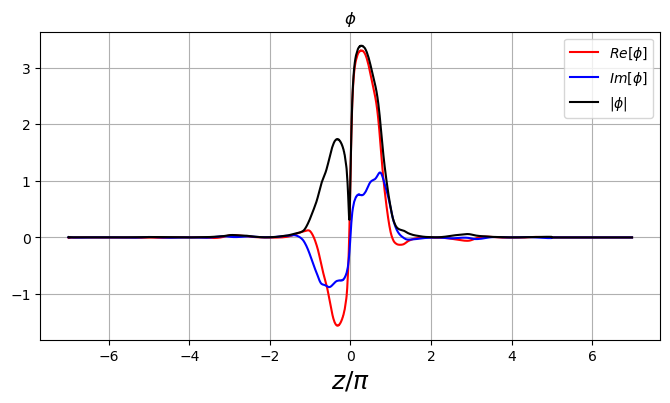

0.0059516834077380934 0.009008625582768623 0.01473353794642857 0.24972098214285712


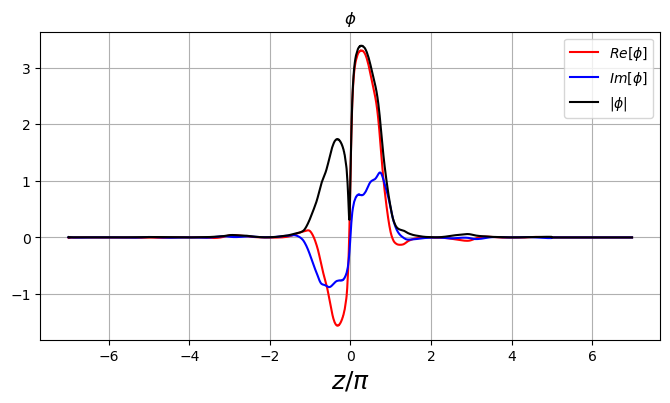

0.005902495941558441 0.009008625582768623 0.014686872914411972 0.24972098214285712


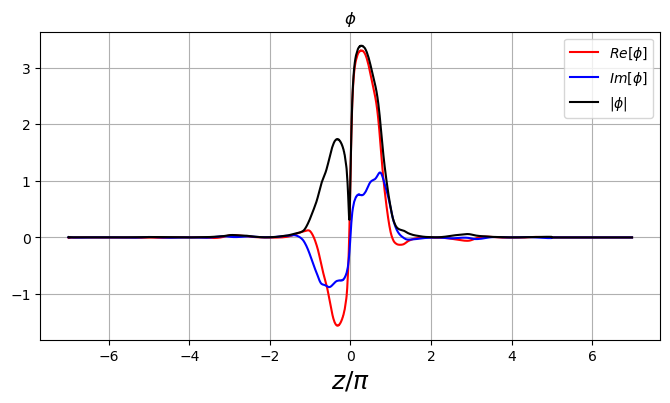

0.001513460497835498 0.00369407803654731 0.008981126837572148 0.24972098214285712


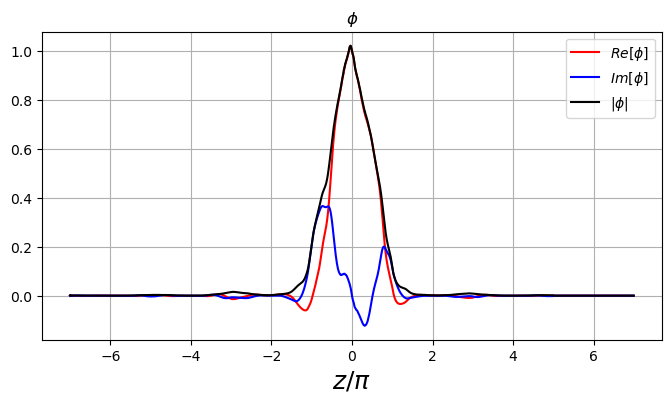

0.001513460497835498 0.00369407803654731 0.009283818937139247 0.24972098214285712


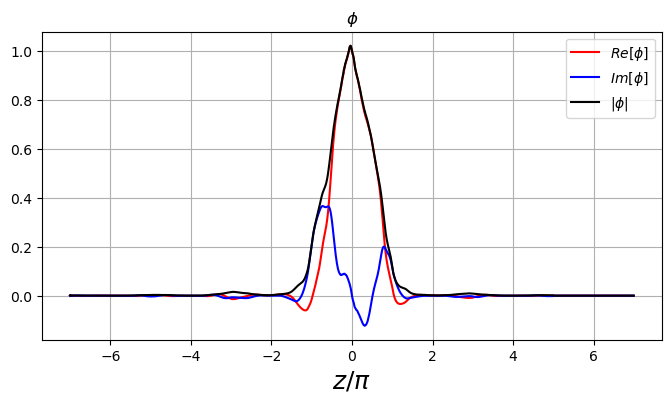

0.0014630118145743146 0.00369407803654731 0.009235892688041121 0.24972098214285712


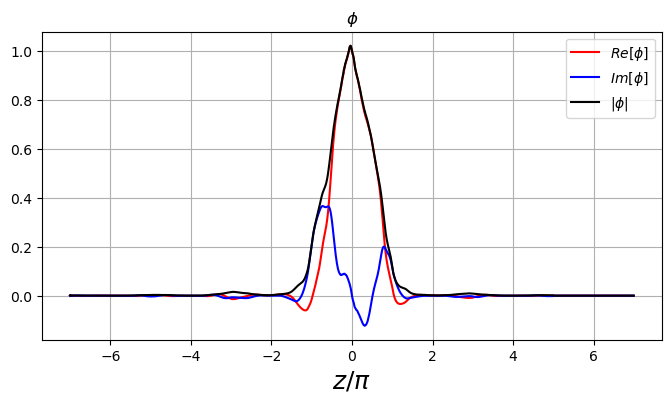

0.00201794733044733 0.004666433302845389 0.011300505050505047 0.24972098214285712


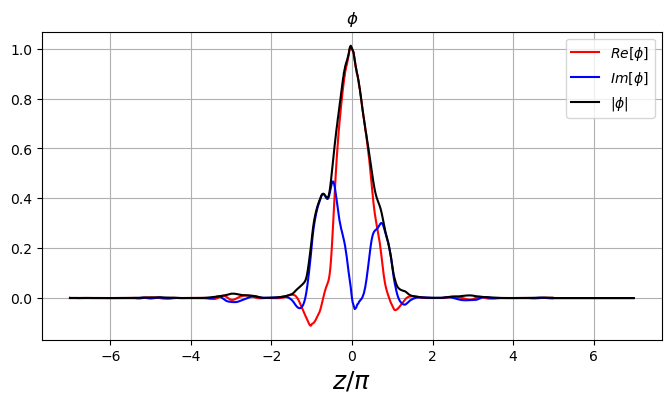

0.00201794733044733 0.004666433302845389 0.010647194602272725 0.24972098214285712


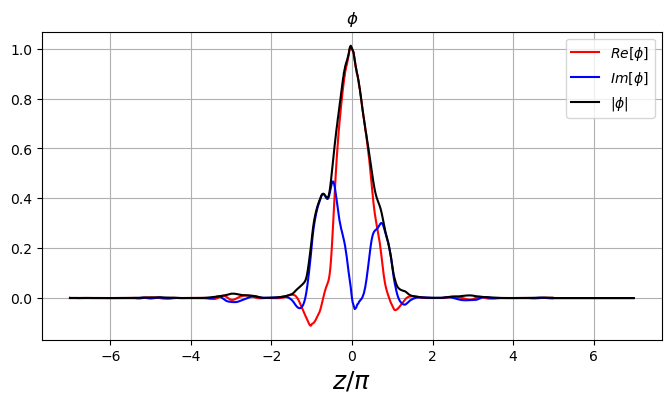

0.002118844696969697 0.004666433302845389 0.010949886701839827 0.24972098214285712


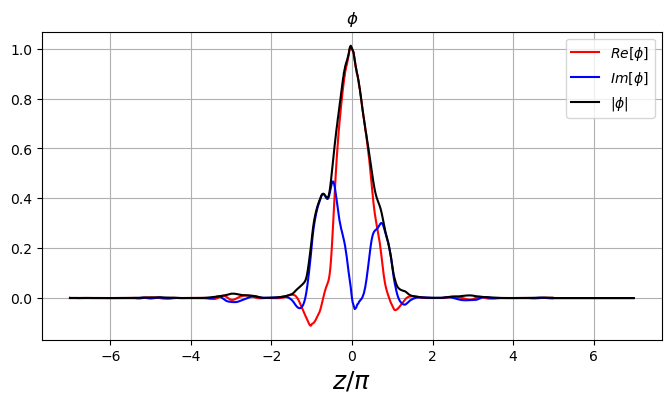

0.009229586602633476 0.01486788826516432 0.022555606286075034 0.24972098214285712


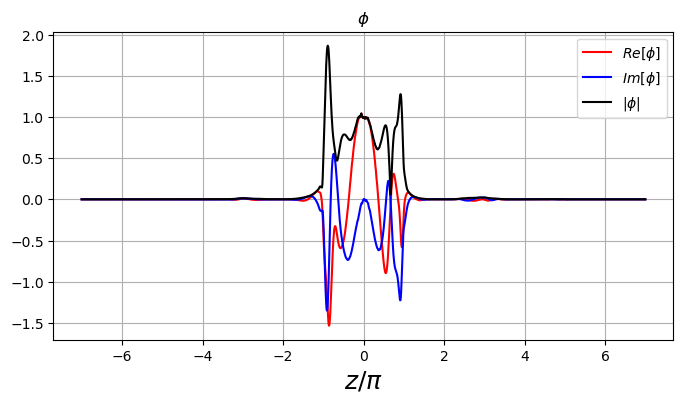

0.00943390376984127 0.01486788826516432 0.024367975232233042 0.24972098214285712


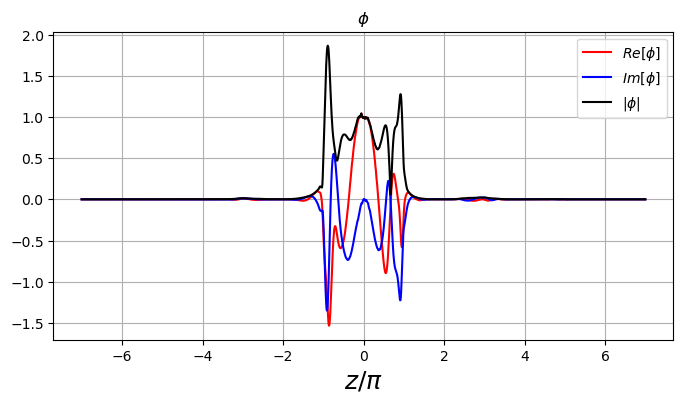

0.009282557720057719 0.01486788826516432 0.023004599567099566 0.24972098214285712


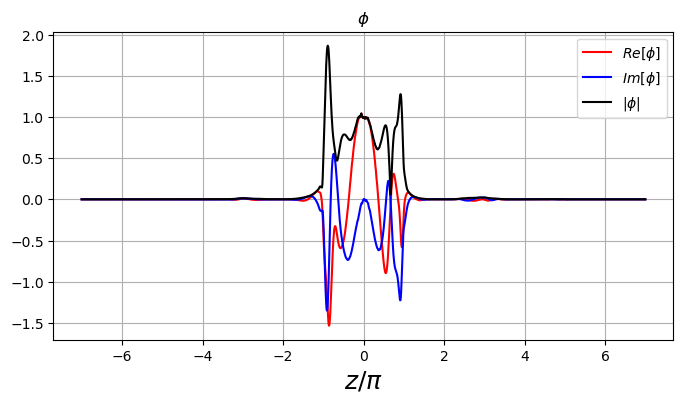

0.03269074675324676 0.04253726447743013 0.054687633872204176 0.24972098214285712


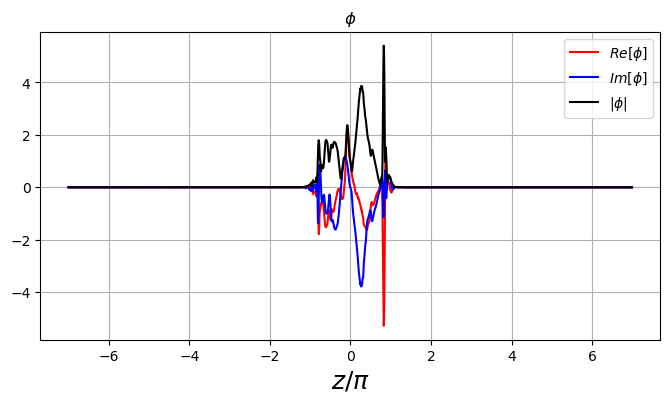

0.03273362813401876 0.04253726447743013 0.05428404440611471 0.24972098214285712


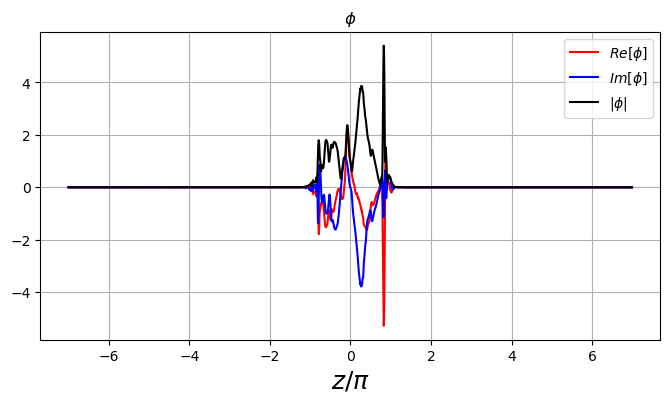

0.015738727960407647 0.02715882384088547 0.04162016369047619 0.24972098214285712


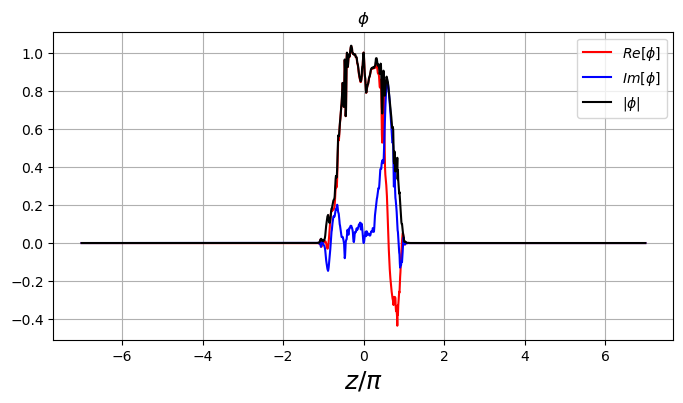

0.016141056209415583 0.02715882384088547 0.04133765106421355 0.24972098214285712


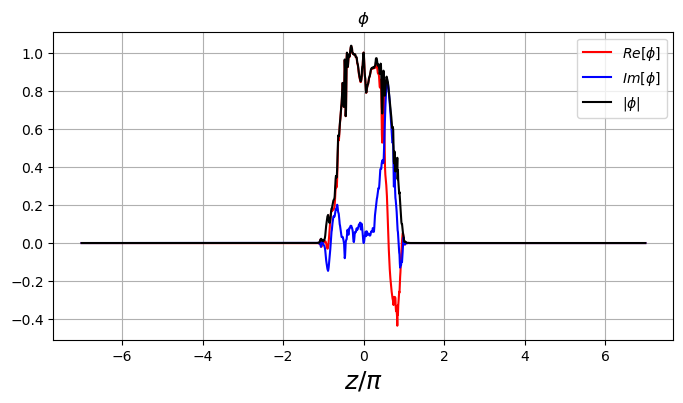

0.008424930104617605 0.01739464425432008 0.027749298227813853 0.24972098214285712


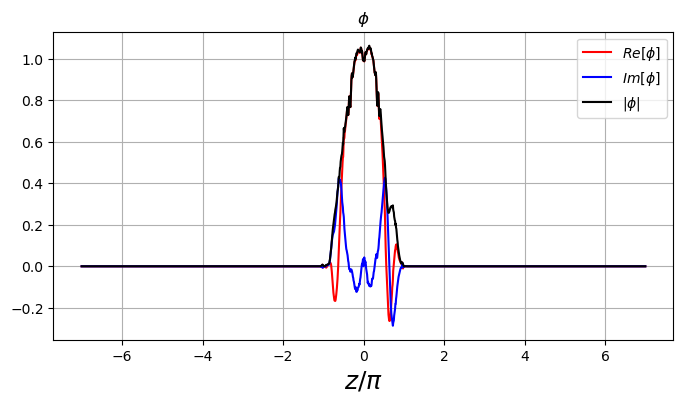

0.009585249819624818 0.01739464425432008 0.027650923295454547 0.24972098214285712


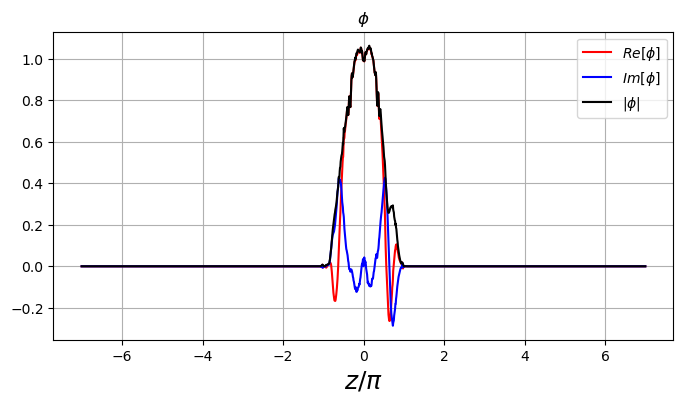

0.007413434005230877 0.015023730553500035 0.026242143815385994 0.24972098214285712


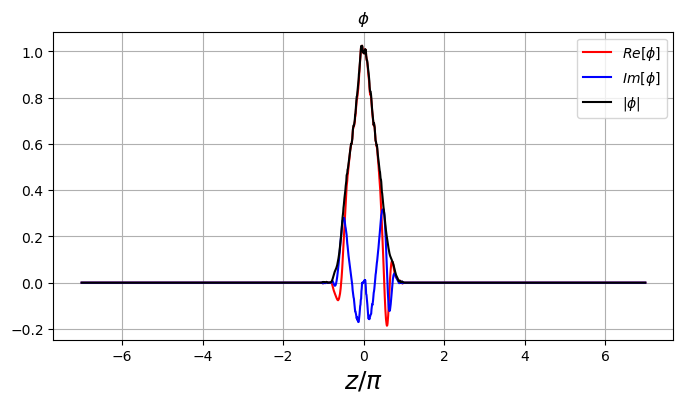

0.007868733371663059 0.015023730553500035 0.025580004847582972 0.24972098214285712


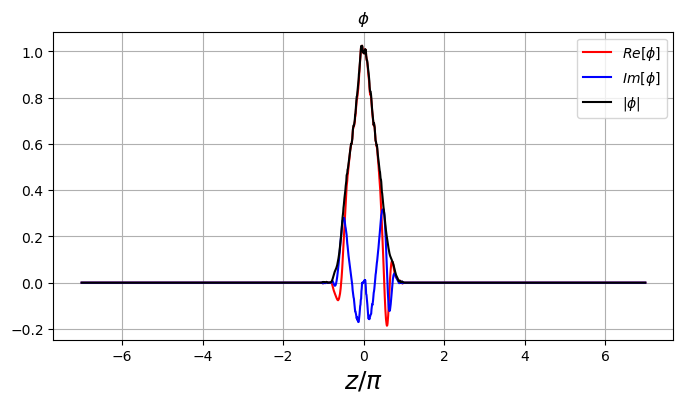

0.008122238005050504 0.015273835215868881 0.025176415381493504 0.24972098214285712


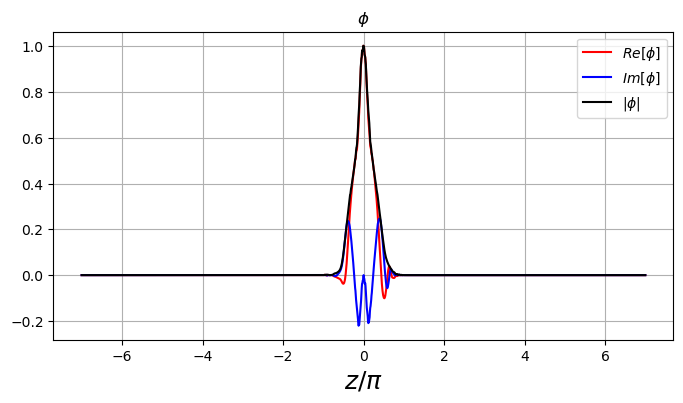

0.008120976787968975 0.015273835215868881 0.02542739758071789 0.24972098214285712


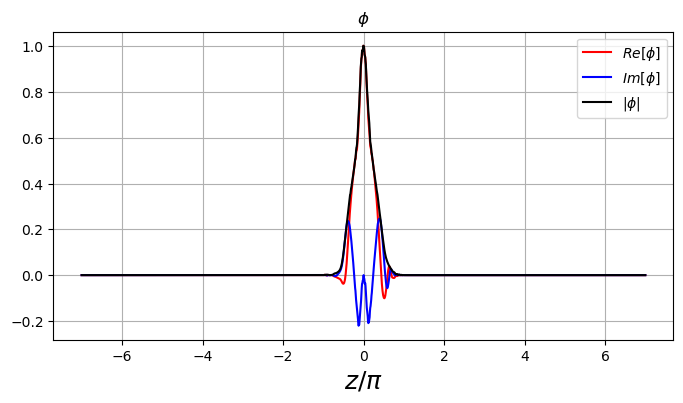

0.009230847819715006 0.016115850638723127 0.026485558712121212 0.24972098214285712


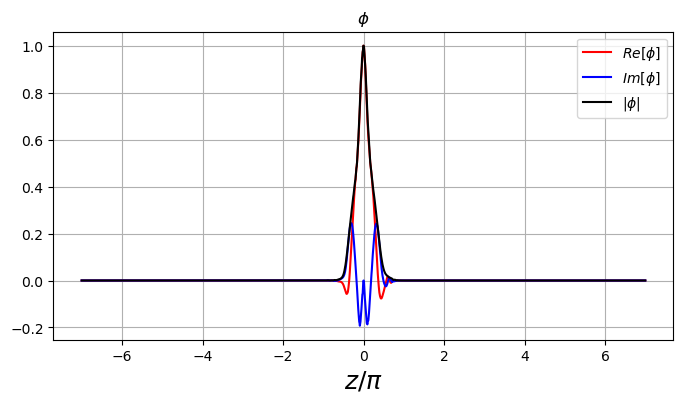

0.00897860440340909 0.016115850638723127 0.026636904761904764 0.24972098214285712


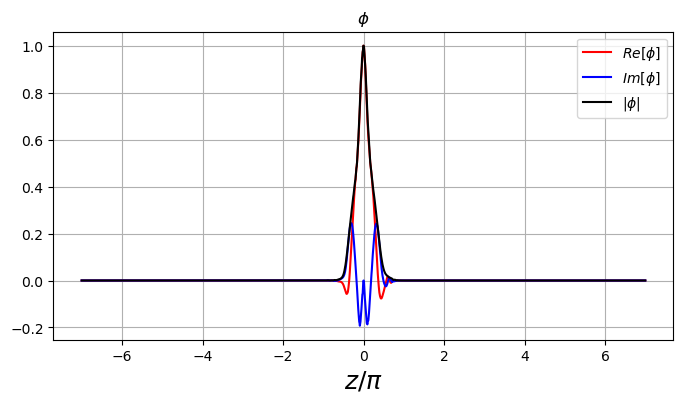

In [16]:
print(analysis_sim_df.columns)

for ind, row in analysis_sim_df.iterrows():

    field_name = 'field_phi'
    phi_array = row[field_name]
    zgrid = row['zgrid']

    if isinstance(phi_array, np.ndarray):
        
        ave_freq = row[f'{field_name}_ave_freq']
        lower_95_freq = row[f'{field_name}_lower_95_freq']
        upper_95_freq = row[f'{field_name}_upper_95_freq']
        max_freq = max(row[f'{field_name}_fft_freq'])

        print(lower_95_freq, ave_freq, upper_95_freq, max_freq/2)

        # if upper_95_freq > max_freq/2:
        plotting_function(phi_array, zgrid, field_name)